# Brute force irrigation experiment

This example notebook shows how the eWaterCycle system can be used to quickly assess the impact of irrigation on river discharge. We will manually overwrite the soil moisture values in an experiment with the PCRGlobWB model, to mimick the effect on irrigation. Obviously, this is not a realistic scenario - the eWaterCycle developers are not accountable for any consequences of implementing a real irrigation system after this example.

In [9]:
from ewatercycle.models import PCRGlobWB
from ewatercycle import CFG

# These packages are not strictly necessary. We'll use them to provide some insight into the steps that we're taking.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy import crs, feature as cfeature

CFG.load_from_file("~/ewatercycle-config.yaml")

We will run 2 versions of the same model:
1. A reference run with the default setup
2. An irrigation experiment where we will overwrite soil moisture values

We will set up the models with identical parameters and settings. We will use a standard dataset with global parameters on 5 and 30 minutes resolution.

In [2]:
input_data = "/mnt/data/examples/technical_paper/pcr-globwb/input"
settings_file = "examples/pcrglobwb_merrimack.ini"

In an earlier experiment we've established a river grid cell that corresponds closely to a GRDC station location. For now, we will use this index without further ado. Further down the notebook, we will show how we originally identified this point.

In [3]:
grdc_latitude = 42.6459
grdc_longitude = -71.2984

model_latitude = 42.63
model_longitude = -71.29

## Reference experiment

For the purpose of illustration, we start by running the reference experiment. Then, in the irrigation experiment, we can focus on the differences with respect to the reference experiment.

In [4]:
# Instantiate the model instance
reference = PCRGlobWB()

# Create experiment folder, set up the model configuration, and start the container in which the model will run
reference_config, reference_dir = reference.setup(input_dir=input_data, cfg_file=settings_file)

Created working directory: /mnt/home/user37/ewatercycle/pcrglobwb_20210421_131937
Created config file /mnt/home/user37/ewatercycle/pcrglobwb_20210421_131937/pcrglobwb_ewatercycle.ini with inputDir /mnt/data/examples/technical_paper/pcr-globwb/input and outputDir /mnt/home/user37/ewatercycle/pcrglobwb_20210421_131937.
Started model container with working directory /mnt/home/user37/ewatercycle/pcrglobwb_20210421_131937 and access to the following input directories:
/mnt/data/examples/technical_paper/pcr-globwb/input.


In [5]:
# Initialize the model inside the container
# This may take a few minutes, log messages will start to appear in the output directory
reference.initialize(str(reference_config))  

In [6]:
# We will use a list to collect discharge values as the model progresses
instantaneous_discharge_values = []

In [7]:
while reference.time < reference.end_time:
    
    # Update the model (takes a few seconds per timestep)
    reference.update() 
    
    # Track discharge at station location
    discharge = reference.get_value_as_xarray('discharge')
    discharge_at_station = discharge.sel(latitude=model_latitude, longitude=model_longitude, method='nearest')
    instantaneous_discharge_values.append(discharge_at_station)
    
    # Show progress
    print(discharge.time.values, end="\r")  # "\r" clears the output before printing the next timestamp

In [10]:
# Combine the instantaneous values of discharge into a single time series
reference_discharge = xr.concat(instantaneous_discharge_values, dim='time')

### Intermediate insights

Before we continue with the experiment, let's have a look at the intermediate results. We start by showing a map of discharge at the last model step.

/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".


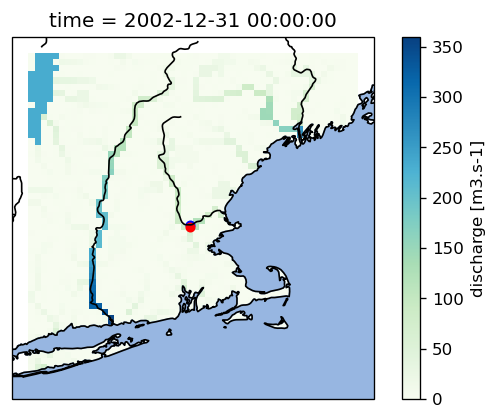

In [51]:
# Use matplotlib to make the figure slightly nicer
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection=crs.PlateCarree())

# Plotting the model field is a one-liner
reference.get_value_as_xarray("discharge").plot(ax=ax, cmap='GnBu')

# Also plot the station location
ax.scatter(grdc_longitude, grdc_latitude, s=25, c='b')
ax.scatter(model_longitude, model_latitude, s=25, c='r')

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN, zorder=2)
ax.add_feature(cfeature.RIVERS, zorder=2, color='k')
ax.coastlines(zorder=3)

You can see that the model grid point we used is very close to the actual GRDC station, and indeed represents a cell that we would identify as a river. Below, we show how we identified that grid point. NB: this method is far from perfect, but is good enough for illustration. It only works after some spin-up time, which is why we couldn't do it before. 

In [14]:
def find_nearby_river(da, latitude, longitude, pad=0.2):
    """Identify a river cell by looking for max discharge in the vicinity of a known station."""
    vicinity = da.sel(longitude=slice(longitude-pad, longitude+pad), latitude=slice(latitude-pad, latitude+pad))
    
    indices_of_maximum = vicinity.argmax(...)
    
    return vicinity.isel(indices_of_maximum)

gridpoint = find_nearby_river(discharge, grdc_latitude, grdc_longitude)
print(gridpoint)

<xarray.DataArray 'discharge' ()>
array(119.18118286)
Coordinates:
    longitude  float64 -71.29
    latitude   float64 42.63
    time       object 2002-12-31 00:00:00
Attributes:
    units:    m3.s-1


We can also have a quick look at the discharge timeseries we have tracked, to see if it makes any sense.

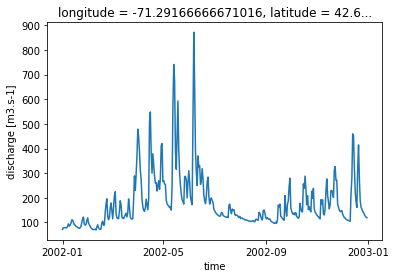

In [15]:
reference_discharge.plot()

## Running the irrigation experiment

Before we initialize the experiment, let's use the reference model to illustrate the concept of what we will do

/mnt/apps/conda/envs/ewatercycle/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".


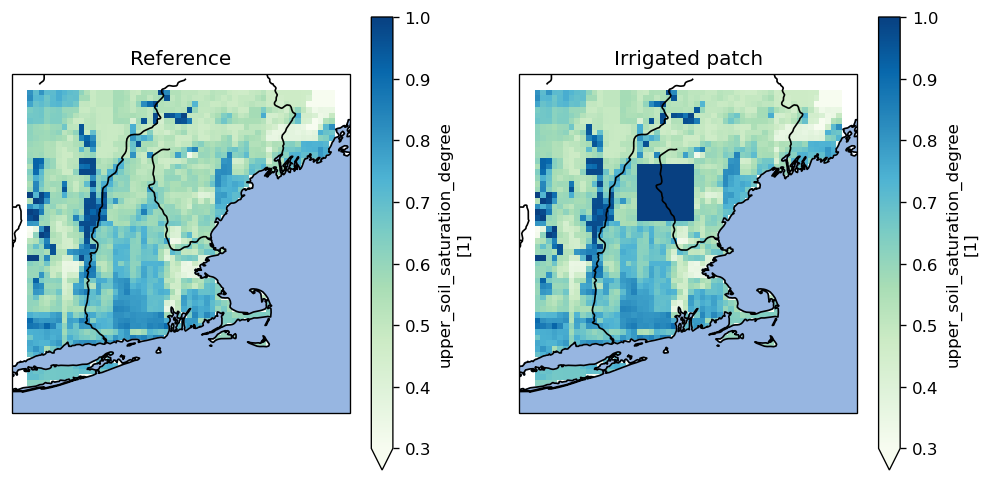

In [53]:
soil_moisture = reference.get_value_as_xarray('upper_soil_saturation_degree')

# Copy the field and manually overwrite a random part of the domain
irrigated_soil_moisture = soil_moisture.copy()
irrigated_soil_moisture[31:41, 18:28] = 1

# Visualize the difference
fig = plt.figure(figsize=(10, 5), dpi=120)
left_axes = fig.add_subplot(121, projection=crs.PlateCarree())
right_axes = fig.add_subplot(122, projection=crs.PlateCarree())

soil_moisture.plot(ax=left_axes, cmap='GnBu', vmin=0.3, vmax=1)
irrigated_soil_moisture.plot(ax=right_axes, cmap='GnBu', vmin=0.3, vmax=1)

# Decoration
left_axes.set_title("Reference")
right_axes.set_title("Irrigated patch")

for axes in [left_axes, right_axes]:
    axes.add_feature(cfeature.OCEAN, zorder=2)
    axes.add_feature(cfeature.RIVERS, zorder=2, color='k')
    axes.coastlines(zorder=3)

From here on we will do exactly the same as before, except that we'll add three extra lines to overwrite soil moisture at every time step.

In [54]:
experiment = PCRGlobWB()
experiment_config, experiment_dir = experiment.setup(input_dir=input_data, cfg_file=settings_file)

Created working directory: /mnt/home/user37/ewatercycle/pcrglobwb_20210421_144753
Created config file /mnt/home/user37/ewatercycle/pcrglobwb_20210421_144753/pcrglobwb_ewatercycle.ini with inputDir /mnt/data/examples/technical_paper/pcr-globwb/input and outputDir /mnt/home/user37/ewatercycle/pcrglobwb_20210421_144753.
Started model container with working directory /mnt/home/user37/ewatercycle/pcrglobwb_20210421_144753 and access to the following input directories:
/mnt/data/examples/technical_paper/pcr-globwb/input.


In [55]:
experiment.initialize(str(experiment_config))  # this may take a few minutes, log messages will start to appear in the output directory.

In [67]:
# Use a list to collect discharge values as the model progresses
instantaneous_discharge_values = []

In [78]:
while experiment.time < experiment.end_time:

    # Update the model (this takes a few seconds per timestep)
    experiment.update() 

    # Overwrite soil moisture field
    soil_moisture = experiment.get_value_as_xarray('upper_soil_saturation_degree', )
    soil_moisture[31:41, 18:28] = 1
    experiment.set_value('upper_soil_saturation_degree', soil_moisture.values.flatten())   
    
    # Track discharge at station location
    discharge = experiment.get_value_as_xarray('discharge')
    discharge_at_station = discharge.sel(latitude=model_latitude, longitude=model_longitude, method='nearest')
    instantaneous_discharge_values.append(discharge_at_station)
    
    # Show progress
    print(discharge.time.values, end="\r")  # "\r" clears the output before printing the next timestamp

In [79]:
# Combine the instantaneous values of discharge into a single time series
experiment_discharge = xr.concat(instantaneous_discharge_values, dim='time')

## Final analysis

Text(0.5, 1.0, 'Increased discharge due to irrigation')

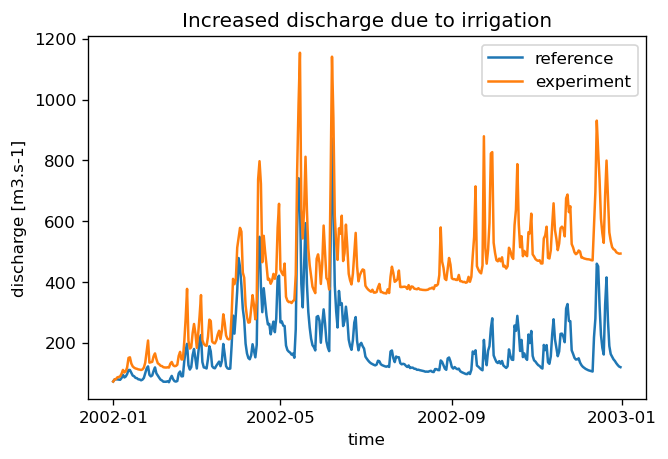

In [80]:
fig, ax = plt.subplots(dpi=120)

reference_discharge.plot(ax=ax, label='reference')
experiment_discharge.plot(ax=ax, label='experiment')
ax.legend()
ax.set_title('Increased discharge due to irrigation')

## Clean up

When you close the notebook the docker containers will eventually be destroyed, but until then, model remnants can put quite some pressure on the system, and it's better to explicitly remove them.

In [168]:
reference.finalize()
experiment.finalize()

del reference
del experiment